# Week 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')



The model of pumping well

h = Q/2/pi*log(r)

r= sqrt[(x-xw)^2+(y-yw)^2]

In [ ]:
def head(x,y,xw=0, yw=0, Q=100, T= 100):
    r= np.sqrt((x-xw)**2+(y-yw)**2)
    return Q/2/np.pi/T * np.log(r)

In [ ]:
x,y= np.meshgrid(np.linspace(0,200,50),np.linspace(-50,50,50))
h = head(x,y,xw=100,Q=200)
plt.figure
cs = plt.contour(x,y,h, np.arange(0.3,1.6,.1))   #the third argument is to determine the value goes from 
plt.axis('scaled')
plt.clabel(cs,fmt = '%1.2f') #2 float digits labels


In [ ]:
class Well:
    def __init__(self, xw, yw, Q, T):
        self.xw = xw
        self.yw = yw 
        self.Q = Q
        self.T = T
    def head(self, x, y):
        r = np.sqrt((x-self.xw)**2+(y-self.yw)**2)
        return self.Q/2/np.pi/self.T * np.log(r)

In [ ]:
w= Well(100,0,200,100)
w.head(200,0)

In [ ]:
h2 = w.head(x,y)
plt.figure()
plt.contour(x,y,h2)
plt.axis('scaled')

** Two Wells**

In [ ]:
class Well_2:
    def __init__(self, xw1, yw1, xw2, yw2, Q1, Q2, T):
        self.xw1 = xw1
        self.yw1 = yw1
        self.xw2 = xw2
        self.yw2 = yw2
        self.Q1 = Q1
        self.Q2 = Q2
        self.T = T
    def head(self, x, y):
        r1 = np.sqrt((x-self.xw1)**2+(y-self.yw1)**2)
        r2 = np.sqrt((x-self.xw2)**2+(y-self.yw2)**2)
        return self.Q1/2/np.pi/self.T * np.log(r1) + self.Q2/2/np.pi/self.T * np.log(r2)

In [ ]:
x,y = np.meshgrid(np.linspace(-150,150,50),np.linspace(-100,100,50))
w = Well_2(-100,0,100,0,200,-200,50)
h = w.head(x,y)
plt.figure()
cs = plt.contour(x,y,h, np.arange(-3,3,.4))
plt.axis('scaled')
plt.clabel(cs,fmt = '%1.2f')

In [ ]:
w = Well_2(-100,0,100,0,200,-200,50)
w.head(-99.7,0)

**Model Class**

In [13]:
class Model:
    def __init__(self,T = 100):
        self.T = T
        self.elementlist = []
    def head(self,x,y):
        pot = 0
        for e in self.elementlist:
            pot += e.potential(x,y)
        return pot/self.T

class Well:
    def __init__(self,Model, xw, yw, Q):
        self.xw = xw
        self.yw = yw 
        self.Q = Q
        self.model = Model
        self.model.elementlist.append(self)
    def potential(self, x, y):
        r = np.sqrt((x-self.xw)**2+(y-self.yw)**2)
        return self.Q/2/np.pi * np.log(r)


In [14]:
ml.head(0,0)

2.9317423955177109

<IPython.core.display.Javascript object>


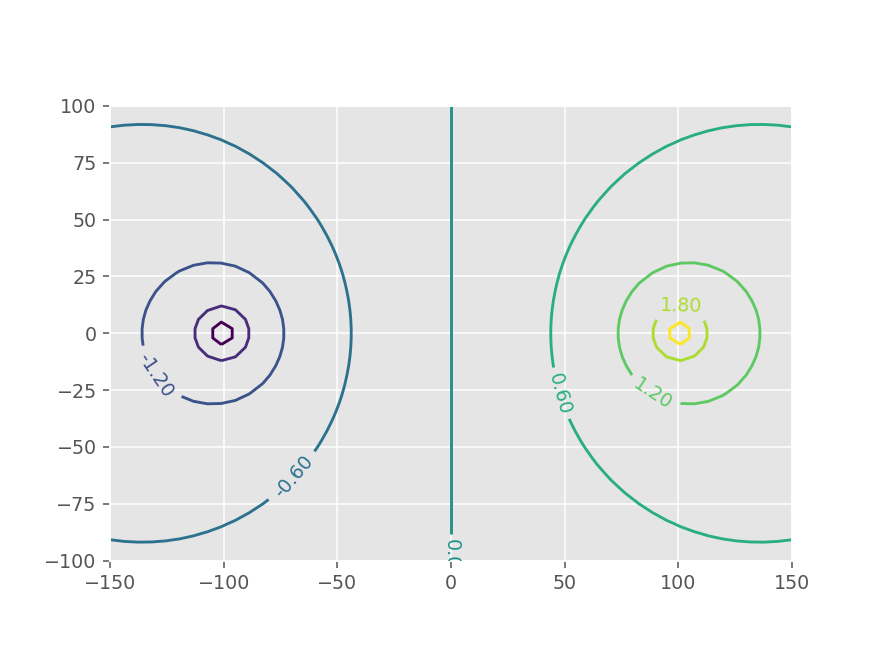

<a list of 6 text.Text objects>

In [15]:
ml = Model(T=50)
w1 = Well(ml, -100,0 , 200)
w2 = Well(ml, 100, 0 ,-200)
xg,yg = np.meshgrid(np.linspace(-150,150,50),np.linspace(-100,100,50))
head = ml.head(xg,yg)
plt.figure()
cs = plt.contour(xg,yg,head, 10)
plt.axis('scaled')
plt.clabel(cs,fmt = '%1.2f')

** Solution of head wells**

In [35]:
class Model:
    def __init__(self,T):
        self.T = T
        self.elementlist = []
    def head(self,x,y):
        potential = 0
        for e in self.elementlist:
            potential += e.potential(x,y)
        return potential/self.T
    def solve(self):
        self.Nunknowns = sum(e.Nunknowns for e in self.elementlist)
        rows = self.Nunknowns
        matrix = np.ones((rows,rows))
        rhs = np.ones((rows))
        i = 0
        for e in self.elementlist:
            if e.Nunknowns>0:
                row,p = e.equation()
                matrix[i] = row
                rhs[i] = p
                i+=1
        Qsol = np.linalg.solve(matrix, rhs)
        irow = 0
        for e in self.elementlist:
            if e.Nunknowns > 0:
                e.Q = Qsol[irow]
                print(e.Q)
                irow = irow + 1
    
class Well:
    def __init__(self,ml,xw,yw,Q):
        self.ml = ml
        self.xw = xw
        self.yw = yw
        self.Q = Q
        self.ml.elementlist.append(self)
        self.Nunknowns = 0
    def potentinf(self,x,y):
        r = np.sqrt((x-self.xw)**2+(y-self.yw)**2)
        return 1/2/np.pi*np.log(r)
    def potential(self,x,y):
        r = np.sqrt((x-self.xw)**2+(y-self.yw)**2)
        return self.Q/2/np.pi*np.log(r)
    
        
class Headwell(Well):
    def __init__(self,ml,xw,yw,h,rw):
        Well.__init__(self,ml,xw,yw,Q=0)
        self.xw = xw
        self.yw = yw
        self.rw = rw
        self.xc = self.xw + self.rw
        self.yc = self.yw
        self.Q = 0
        self.pot = self.ml.T * h
        self.h = h
        self.Nunknowns = 1
    def equation(self):
        row = np.zeros(self.ml.Nunknowns)
        rhs = self.pot
        icol = 0
        for e in self.ml.elementlist:
            if e.Nunknowns > 0:
                row[icol] = e.potentinf(self.xc, self.yc)
                icol += 1
            else:
                rhs += -e.potential(self.xc, self.yc)
        return row, rhs

262.124448692
261.930050206


<IPython.core.display.Javascript object>


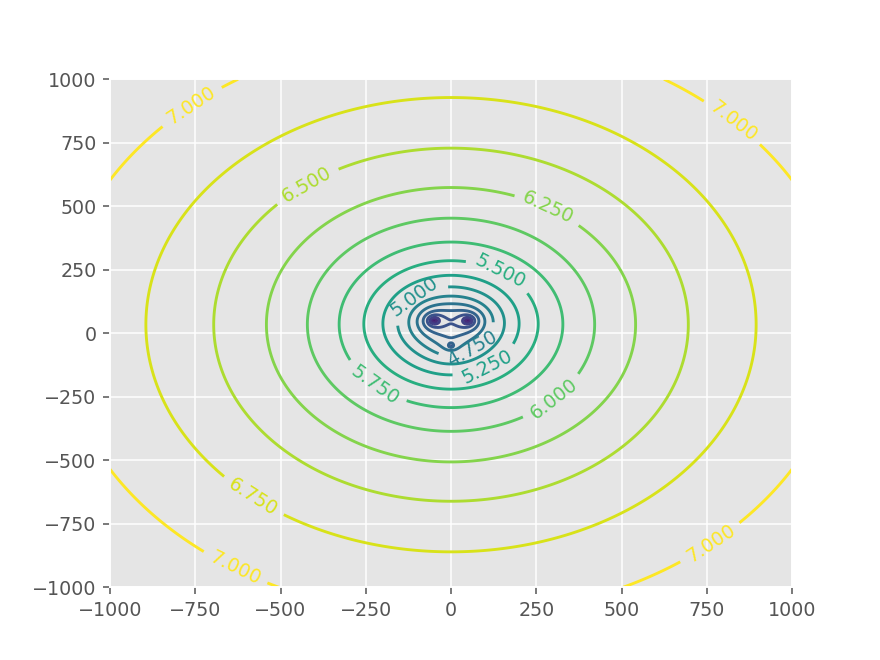

<a list of 13 text.Text objects>

In [36]:
ml = Model(T = 100)
w1 = Well(ml, xw=0, yw= -50 ,Q = 100)
w2 = Headwell(ml,xw = 50, yw= 50,h=2,rw = 0.2)
w3 = Headwell(ml,xw = -50, yw= 50,h=2,rw = 0.2)
ml.solve()
x,y = np.meshgrid(np.linspace(-1000,1000,1000),np.linspace(-1000,1000,1000))
plt.figure()
cs = plt.contour(x,y,ml.head(x,y),20)
plt.clabel(cs)